In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm, PowerNorm



from scipy import interpolate
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.misc import imread

In [3]:
def make_historical_diagram():
    '''
    do all of the stuff for the graphics of making a hurricane plot
    
    takes in the year dataframe in order to get the necessary data
    
    returns ax which is the figure axis that the current hurricane track will be added upon
    '''
    # establish the figure
    figure = plt.figure(figsize=(19.2, 12.0), dpi=100)
    
    axis = figure.add_subplot(111)
    axis.set_facecolor("#000000")
    
    axis.set_xlim(-120.0, -30.0)
    axis.set_ylim(0, 50.0)
    
    return figure, axis
    
def heatmap(ax, storm):
    '''
    make a heatmap of storm track?
    '''
    x, y = storm_heat(storm)
    
    ax.hexbin(x, y, gridsize=50, bins="log", cmap="inferno")
    
    # ax.hexbin(x, y, gridsize=50, bins='log', cmap='inferno')
    
def storm_heat(storm):
    '''
    make storm track into two lists that will be turned into a heatmap
    '''
    _x = []
    _y = []
    
    if len(storm) >= 5:
        interpolation_multiplier = 120

        _lat = storm.Latitude.apply(lambda x: float(x))
        _long = storm.Longitude.apply(lambda x: float(x))

#         _strengths = storm.loc[:,"Wind(WMO)"].apply(lambda x: int(((x / 165.0) * 5.0)**2))
        
        # since the 'saffir_simpson_cat' column ranges from -1 to 5 add 2 to it
        # so that the range is 1 <-> 7 which a computer understands better
        _strengths = storm.loc[:, "saffir_simpson_cat"].apply(lambda x: int((x + 2)**2))
        
        new_length = interpolation_multiplier * len(_lat)

        x = np.arange(len(_lat))

        # figure out length of new arrays
        new_x = np.linspace(x.min(), x.max(), new_length)

        # actually do the interpolation
        new_lat = interpolate.interp1d(x, _lat, kind='cubic')(new_x)
        new_long = interpolate.interp1d(x, _long, kind='cubic')(new_x)
        new_strs = interpolate.interp1d(x, _strengths, kind='cubic')(new_x)
        
        for idx in range(len(new_lat)):
            _strength = int(new_strs[idx])
            for idy in range(_strength):
                _x.append(new_long[idx])
                _y.append(new_lat[idx])

    return _x, _y

def safsimpsonize(wind):
    '''
    Takes in wind speed
    
    Returns saffir-simpson hurricane category with 0 and -1 for tropical storm/depression
    which doesn't make perfect sense as scales go but this maintains categories but allows
    the model/visualization to detect when something is a tropical depression
    
    According to: https://en.wikipedia.org/wiki/Saffir%E2%80%93Simpson_scale
    
    Return:  Category:   Wind Speed Range: (mph, seriously?)
    5        Cat 5      157 <= v
    4        Cat 4      130 <= v < 157
    3        Cat 3      111 <= v < 130
    2        Cat 2      96 <= v < 111
    1        Cat 1      74 <= v < 96
    0        Storm      39 <= v < 74
    -1       Depression v < 39
    '''
    if wind >= 157:
        return 5
    elif wind >= 130:
        return 4
    elif wind >= 111:
        return 3
    elif wind >= 96:
        return 2
    elif wind >= 74:
        return 1
    elif wind >= 39:
        return 0
    else:
        return -1

def load_hurricane_data(_path="../data/allstorms.csv"):
    data = pd.read_csv(_path)

    # data dictionary
    # N/A,Year,#,BB,BB,N/A,YYYY-MM-DD HH:MM:SS,N/A,deg_north,deg_east,kt,mb,N/A,%,%,N/A

    data.loc[:,"Season"] = data.loc[:,"Season"].apply(lambda x: int(x))

#     print data.loc[:,"Basin"].unique()
    # array(['BB', ' SI', ' NA', ' EP', ' SP', ' WP', ' NI', ' SA'], dtype=object)

    data.loc[:, "Basin"] = data.loc[:, "Basin"].apply(lambda x: x.replace(" ", ""))

#     print data.loc[:,"Basin"].unique()
    # ['BB' 'SI' 'NA' 'EP' 'SP' 'WP' 'NI' 'SA']

    data_na = data[data.loc[:, "Basin"] == "NA"]
    
    data_na.loc[:,"saffir_simpson_cat"] = data_na["Wind(WMO)"].apply(lambda x: safsimpsonize(x))

    # try to give back memory
    del data
    
    return data_na

def get_data_as_yearlist(start_year, end_year):
    '''
    take in data frame (north atlantic most likely) and turn it into a list of dataframes
    with each entry being a dataframe holding a year's data
    '''
    # load data frame that we want
    data_na = load_hurricane_data()
    
    # make a list for the years
    years = []

    # step through the Seasons (years) and make a new dataframe for each one
    for year in data_na.loc[:, "Season"].unique():
        temp = data_na[data_na.loc[:, "Season"] == year]
        years.append(temp)

    # get rid of a nan DataFrame
    years.pop(0)

    #loop through years in future gif
    start = 164 - (2016 - start_year)
    end = 164 - (2016 - end_year)
    
    if start != end:
        temp = years[start:end]
    else:
        # handle case where only one year is wanted
        temp = []
        temp.append(years[start])
    
    # try to give back memory
    del years
    
    return temp

def get_storms_from_year(year_df):
    '''
    year_df is the dataframe with a year's data
    
    returns a list of smaller dataframes each consisting of a 
    unique storm track
    '''
    storms = []
    
    # step through the year and make a dataframe for each storm
    for storm in year_df.loc[:,"Serial_Num"].unique():
        storms.append(year_df[year_df.loc[:, "Serial_Num"] == storm])
        
    return storms

In [4]:
def get_map_data(_start=1915, _end=2016):
    # extract data from dataframe into a usable matrix form
    #
    # establish the range of years
    # ^ moved to function parameter

    # make a list of year dataframes for the range
    years = get_data_as_yearlist(_start, _end)

    big_x = []
    big_y = []

    # make a temp list to hold the storm dataframes from a single year
    for _idx, year in enumerate(years):

        storms = get_storms_from_year(year)

        for z, storm in enumerate(storms):

            x, y = storm_heat(storm)

            big_x += x
            big_y += y

    x = np.array(big_x)
    y = np.array(big_y)

    temp_x = []
    temp_y = []

    for idx in range(x.shape[0]):
        if 10 <= y[idx] <= 50 and -120 <= x[idx] <= -30:
            temp_x.append(x[idx])
            temp_y.append(y[idx])

    x = np.array(temp_x)
    y = np.array(temp_y)
    
    return x, y


def gridsearch_draw_map(grid_scale, x, y, _xs, _ys, gam1=1.0, gam2=2.0, file_name=None, color_map=0):
    '''
    Perform a randomized grid search of hyper parameters used to make diagrams
    
    Looking for hyperparameters that would not have occurred through normal thought
    processes.
    
    Output:
    writes a png with the resulting image as well as the hyperparameters to make it
    '''

    color_dict = {0:"inferno", 1:"plasma", 2:"magma", 3:"viridis", 4:"hot", 5:"afmhot",
                 6:"gist_heat", 7:"copper", 8:"bone", 9:"gnuplot", 10:"gnuplot2",
                  11:"CMRmap", 12:"pink", 13:"spring", 14:"autumn_r", 15:"cool",
                 16:"Wistia", 17:"seismic", 18:"RdGy_r", 19:"BrBG_r", 20:"RdYlGn_r",
                 21:"PuOr", 22:"brg", 23:"hsv", 24:"cubehelix", 25:"gist_earth",
                 26:"ocean", 27:"gist_stern", 28:"gist_rainbow_r", 29:"jet", 
                 30:"nipy_spectral", 31:"gist_ncar"}
    
    _cmap = color_dict[color_map]
    
    
    grid = np.zeros((int(40 * grid_scale), int(90 * grid_scale)))
    grid2 = np.zeros((int(40 * grid_scale), int(90 * grid_scale)))
    
#     print grid.shape

    for idx in range(x.shape[0]):
        _Y = int(50 * grid_scale) - 2 - int(y[idx] * grid_scale)
        # was a -1 adjustment because counting starts at 0, changing to -2 because
        # storms tend to start on the right side and not hit the left side
        # so this is a hack-ey fix for what seems like a rounding problem
        _X = int(120 * grid_scale) - 2 + int(x[idx] * grid_scale)

        grid[_Y, _X] += 1
        
    for idy in range(_xs.shape[0]):
        _Ys = int(50 * grid_scale) - 2 - int(_ys[idy] * grid_scale)
        # was a -1 adjustment because counting starts at 0, changing to -2 because
        # storms tend to start on the right side and not hit the left side
        # so this is a hack-ey fix for what seems like a rounding problem
        _Xs = int(120 * grid_scale) - 2 + int(_xs[idy] * grid_scale)
        
        grid2[_Ys, _Xs] += 1

    # establish the figure
    fig = plt.figure(figsize=(19.2, 24.0), dpi=100)

    ax = fig.add_subplot(111)
    ax.set_facecolor("#000000")
    ax.clear()  # maybe clear erases some of the axis settings, not just the canvas?
    fig.subplots_adjust(0, 0, 1, 1)

    ax.set_xlim(-120.0, -30.0)
    ax.set_ylim(10, 50.0)

#     map_image = imread("../data/grey_blue_na_2.png")

#     ax.imshow(map_image, extent=[-120, -30, 10, 50], aspect="auto")

    ax.imshow(grid, norm=PowerNorm(gamma=gam1/gam2), cmap=_cmap, extent=[-120, -30, 10, 30], alpha=1.0, aspect="auto")
    ax.imshow(grid2, norm=PowerNorm(gamma=gam1/gam2), cmap=_cmap, extent=[-120, -30, 30, 50], alpha=1.0, aspect="auto")
    
    # write out file info so we can see how a map was made later w/ grid search
    desc = "grid_scale: {:2.2f}\n gam1: {:2.2f}\n gam2: {:2.2f}\n _cmap: {}".format(grid_scale, gam1, gam2, _cmap)
    ax.annotate(desc, xy=(-119, 43.8), size=30, color='#D0D0D0')
    
    if file_name != None:
        fig.savefig("../imgs/test/grid_heat/{}".format(file_name), pad_inches=0, transparent=True)
        plt.close("all")

    del _X, _Y, _Xs, _Ys
    
def run_map_grid_search(x, y, xs, xy, _start=0, _end=1000):
    '''
    Pick hyper parameters to use in a randomized grid search to try to 
    find a good looking heatmap setup
    '''
    
    for rdx in range(_start, _end):
        print "Making map [{:0>4}]/1000\r".format(rdx),
        _filename = "cmap_gsearch_num{:0>4d}.png".format(rdx)
        
        # pick grid_scale from lognormal distribution
        # with these values min/max of 10,000 test sample is ~0.5, 21.4
        mu, sigma = 1.2, 0.5
        # returns a numpy array so steal the first value in that to actually get the value
        _grid_scale = np.random.lognormal(mu, sigma, 1)[0]

        # gamma 1: pull from a normal distribution centered around 1.0
        norm_mu, norm_sigma = 1.5, 0.5

        _gam1 = np.random.normal(norm_mu, norm_sigma, 1)[0]

        # we don't want the value to go negative so if it is negative set it to 1.0
        if _gam1 <= 0:
            _gam1 = 1.0

        #, gamma 2, cmap? if so what cmap?
        g2_mu, g2_sigma = 3.0, 1.0

        do_over = 0

        _gam2 = -10

        # we want to keep picking until _gam2 is bigger than _gam1
        # but prevent infinite loops because that's really annoying
        while _gam2 < _gam1 or do_over < 1000:
            # break infinite loop
            do_over += 1
            _gam2 = np.random.normal(g2_mu, g2_sigma, 1)[0]

        # about 2/3rds the time use the non-standard color map
        _color_map = np.random.randint(0, 32)

    #     draw_map(grid_scale, x, y, _xs, _ys, gam1=1.0, gam2=2.0, file_name=None, color_map=0)
        draw_map(_grid_scale, x, y, xs, xy, _gam1, _gam2, color_map=_color_map, file_name=_filename)
        
def easy_buffer(_filename, h, w):
    '''
    load file with filename, turn into np buffer
    
    returns:
    new np buffer
    '''
    # load track file
    storm_tracks = imread("../imgs/xplots4/{}".format(_filename))
    
    new_buffer = np.frombuffer(storm_tracks, np.uint8)
    
    temp_buffer = new_buffer.astype(np.int16).reshape(h, w, 4) #int16 so we dont overflow
    
#     print "new_buffer shape:", temp_buffer.shape
    
#     print "max heat:", temp_buffer[..., 1].max()
    
    temp_buffer[temp_buffer[:, :, -1] == 0] = 0
    
    return temp_buffer
        
def add_layer_to_buffer(_filename):
    '''
    Takes in a numpy array buffer
    loads historical plot from _filename
    draws that plot using fig/ax
    adds that new buffer to the existing buffer
    
    Returns:
    _buffer with new image added
    '''
    # load track file
    storm_tracks = imread("../imgs/xplots4/{}".format(_filename))
    
    print "storm_tracks shape:", storm_tracks.shape
    
    # establish the figure
    figure = plt.figure(figsize=(19.2, 12.0), dpi=100)

    axis = figure.add_subplot(111)
    axis.set_facecolor("#000000")
    axis.clear()  # maybe clear erases some of the axis settings, not just the canvas?
    figure.subplots_adjust(0, 0, 1, 1)
    
    axis.set_xlim(-110.0, -30.0)
    axis.set_ylim(10, 50.0)
#     ax.tick_params(directio
    
    # get canvas dimensions
    w, h = figure.canvas.get_width_height()
    
    new_buffer = np.frombuffer(figure.canvas.buffer_rgba(), np.uint8)
    
    # the first buffer which is used for the new track in color
    temp_buffer = new_buffer.astype(np.int16).reshape(h, w, -1) #int16 so we dont overflow
    temp_buffer[temp_buffer[:, :, -1] == 0] = 0 # Set transparent pixels to 0
    


    # clean up canvas for new image
    axis.clear()
    
    # test to see if this part is really necessary
    axis.set_xlim(-110.0, -30.0)
    axis.set_ylim(10.0, 50.0)
    
    # also probably cargo cult but set the face to black:
    axis.patch.set_facecolor('#000000')
    
    # draw the new tracks on the canvas
    axis.imshow(storm_tracks, extent=[-110, -30, 10, 50], aspect="auto")
    
    # apply the changes to the canvas
    figure.canvas.draw()
    
    # pull the color values from the canvas
    img = np.frombuffer(figure.canvas.buffer_rgba(), np.uint8).astype(np.int16).reshape(h, w, -1)
    
    # maybe yet more cargo cult esp since we're loading tracks w/ transparent backgrounds
    img[img[:, :, -1] == 0] = 0 # Set transparent pixels to 0
    
    temp_buffer += img
    
    return temp_buffer
    
def establish_canvas():
    '''
    basic canvas configuration for matplotlib
    
    Returns:
    fig, ax to use for the diagram
    '''
    # establish the figure
    fig = plt.figure(figsize=(19.2, 12.0), dpi=100)

    ax = fig.add_subplot(111)
    ax.set_facecolor("#000000")
    ax.clear()  # maybe clear erases some of the axis settings, not just the canvas?
    fig.subplots_adjust(0, 0, 1, 1)
    
    ax.set_xlim(-110.0, -30.0)
    ax.set_ylim(10, 50.0)
    
    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    _buffer = np.frombuffer(fig.canvas.buffer_rgba(), np.uint8)
    
    # the first buffer which is used for the new track in color
    main_buffer = _buffer.astype(np.int16).reshape(h, w, -1) #int16 so we dont overflow
    main_buffer[main_buffer[:, :, -1] == 0] = 0 # Set transparent pixels to 0
    
    return fig, ax, main_buffer
    
def draw_map(grid_scale, gam1=1.0, gam2=2.0, file_name=None, color_map=0, year='', _alpha=1.0):

    color_dict = {0:"inferno", 1:"plasma", 2:"magma", 3:"viridis", 4:"hot", 5:"afmhot",
                 6:"gist_heat", 7:"copper", 8:"bone", 9:"gnuplot", 10:"gnuplot2",
                  11:"CMRmap", 12:"pink", 13:"spring", 14:"autumn_r", 15:"cool",
                 16:"Wistia", 17:"seismic", 18:"RdGy_r", 19:"BrBG_r", 20:"RdYlGn_r",
                 21:"PuOr", 22:"brg", 23:"hsv", 24:"cubehelix", 25:"gist_earth",
                 26:"ocean", 27:"gist_stern", 28:"gist_rainbow_r", 29:"jet", 
                 30:"nipy_spectral", 31:"gist_ncar"}
    
    _cmap = color_dict[color_map]

    # make the canvas
    fig, ax, first = establish_canvas()    
    w, h = fig.canvas.get_width_height()

    # load in the background map image file
    map_image = imread("../data/new_ultra_map.png")

    # draw the map
    ax.imshow(map_image, extent=[-110, -30, 10, 50], aspect="auto")
    
    # paint the canvas so we can pull it into a map buffer
    fig.canvas.draw()
    
    # get the map image into a buffer
    map_img = np.frombuffer(fig.canvas.buffer_rgba(), np.uint8).astype(np.int16).reshape(h, w, -1)
    map_img[map_img[:, :, -1] == 0] = 0  
    
    print "max map heat:", map_img[..., 1].max()
    
    first += map_img

    ###############################################
    ### Finish the standard base of the diagram ###
    ###############################################
    
    # make a new buffer for the heatmap itself
    ax.clear()
    ax.set_xlim(-110.0, -30.0)
    ax.set_ylim(10.0, 50.0)
    ax.set_facecolor('#000000')
#     _heatmap = np.frombuffer(fig.canvas.buffer_rgba(), np.uint8)
#     _heatmap = _heatmap.astype(np.int16).reshape(h, w, -1) #int16 so we dont overflow
    
#     # see if we really need this...
#     _heatmap[_heatmap[:, :, -1] == 0] = 0 # Set transparent pixels to 0
    _heatmap = np.zeros(shape=(h, w, 4))
    
    # how many years to include in the heatmap part
    for x in range(1):
        # which year to start pulling heatmaps
        _year_zero = 1915
        
        # figure out the filename for the current year
        _filename = "xplot_{}.png".format(_year_zero + x)
        
        # load the transparent background map and add it's values to the buffer
        _heatmap += easy_buffer(_filename, h, w)

    print "max heat coming out of layer processing:", _heatmap[..., 1].max()
    
    # currently the buffer is RGBA but since it's grey we only need one channel
    _buff = _heatmap[...,1]
    # max heat is 1500 so it seems like data is being loaded ok
        
    # prepare to draw the new buffer
    ax.clear()  # maybe clear erases some of the axis settings, not just the canvas?
    ax.set_xlim(-110.0, -30.0)
    ax.set_ylim(10, 50.0)
    ax.patch.set_facecolor('#000000')
    
    # draw the new combined heatmap
    ax.imshow(_buff, norm=PowerNorm(gamma=gam1/gam2), cmap=_cmap, extent=[-110, -30, 10, 50], alpha=1.0, aspect="auto")
    
#     fig.savefig("../imgs/test/heat_render/test_more.png", pad_inches=0, transparent=True)
    # paint the canvas
    fig.canvas.draw()    
    
    # pull the paint back off the canvas into the buffer
    heat_img = np.frombuffer(fig.canvas.buffer_rgba(), np.uint8).astype(np.int16).reshape(h, w, -1)
    
    print "max heat from heatmap buffer:", heat_img[..., 1].max()
    # make transparent parts black
#     heat_img[heat_img[:, :, -1] == 0] = 0  
    
    # and black parts transparent (if they're not already)
    heat_img[((heat_img[:,:,0] == 0) & (heat_img[:,:,1] == 0) & (heat_img[:,:,2] == 0))] = 0
    
    # add the heatmap to the final buffer
    first += heat_img
    
    print "max final heat:", first[..., 1].max()
    
    ###############################################
    ### Finish the dynamic heatmap part of plot ###
    ###############################################
    
    ax.clear()  # maybe clear erases some of the axis settings, not just the canvas?
    ax.set_xlim(-110.0, -30.0)
    ax.set_ylim(10.0, 50.0)
    ax.patch.set_facecolor('#000000')
    
    
    
#     ax.imshow(layer_1, norm=PowerNorm(gamma=gam1/gam2), cmap=_cmap, extent=[-110, -30, 10, 50], alpha=_alpha, aspect="auto")
    
    
#     for a in range(heat_img.shape[0]):
#         for b in range(heat_img.shape[1]):
#             # if heatmap is black then make it transparent
#             if heat_img[a][b][0] <= 1 and heat_img[a][b][1] <= 1 and heat_img[a][b][2] <= 1:
#                 heat_img[a, b, :] = 0
                
#             # if map_img is relatively high then make heatmap alpha 0
#             if map_img[a][b][0] >= 30 and map_img[a][b][1] >= 30 and map_img[a][b][2] >= 30:
#                 heat_img[a][b][3] = 128
#                 heat_img[a][b][0] = heat_img[a][b][0] // 2
#                 heat_img[a][b][1] = heat_img[a][b][1] // 2
#                 heat_img[a][b][2] = heat_img[a][b][2] // 2
    
    first = np.clip(first, 0, 255) # clip buffer back into int8 range
                    # wonder if some kind of exp transform
                    # might enable hdr-like effect    
    
    
    # make the final draw
    ax.imshow(first.astype(np.uint8), extent=[-110, -30, 10, 50], aspect='auto', alpha=1.0)
    # write out file info so we can see how a map was made later w/ grid search
    desc = "Year: {}".format(year)
    ax.annotate(desc, xy=(-109, 48), size=40, color='#707070')
    
    if file_name != None:
        fig.savefig("../imgs/test/heat_render/{}".format(file_name), pad_inches=0, transparent=True)
        plt.close("all")

In [137]:
draw_map(10.28, 3.5, 4.0, color_map=0, year="2002-2006", _alpha=1.0, file_name="test_0.png")

max map heat: 255
max heat coming out of layer processing: 146.0
max heat from heatmap buffer: 254
max final heat: 354


In [91]:
1530 / 255.0

6.0

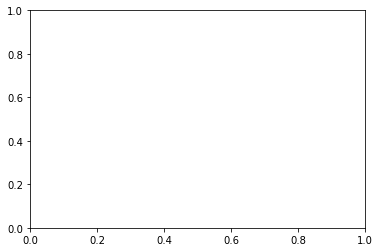

In [5]:
fig, ax = plt.subplots()

In [6]:
fig.canvas.tostring_argb

<bound method FigureCanvasAgg.tostring_argb of <matplotlib.backends.backend_agg.FigureCanvasAgg object at 0x7f523dcb2290>>